## Week 3 Mini Project

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import shutil
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.models import Model

## EDA

(220025, 2)
First few rows of the dataset:
                                         id label
0  f38a6374c348f90b587e046aac6079959adf3835     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77     1
2  755db6279dae599ebb4d39a9123cce439965282d     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08     0
4  068aba587a4950175d04c680d38943fd488d6a9d     0
5  acfe80838488fae3c89bd21ade75be5c34e66be7     0
6  a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da     1
7  7f6ccae485af121e0b6ee733022e226ee6b0c65f     1
8  559e55a64c9ba828f700e948f6886f4cea919261     0
9  8eaaa7a400aa79d36c2440a4aa101cc14256cda4     0
Total images: 220025
Unique labels: ['0' '1']


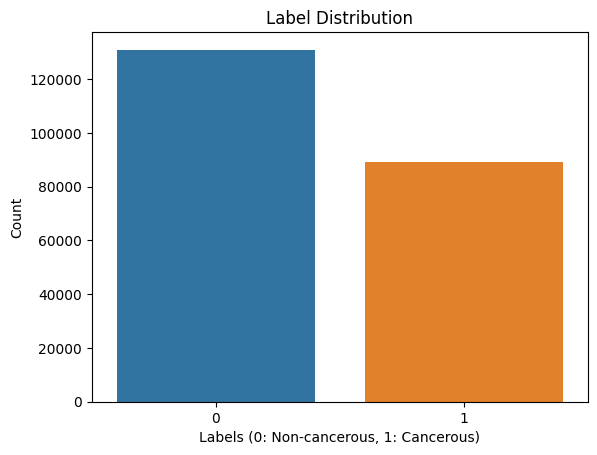

Missing images: 0
Duplicate rows in the dataset: 0


In [2]:
# Load the data
data_path = '/kaggle/input/histopathologic-cancer-detection'  # Update with the actual path
labels_csv = os.path.join(data_path, 'train_labels.csv')
images_path = os.path.join(data_path, 'train')
test_images_path = os.path.join(data_path, 'test')

# Read CSV
labels_df = pd.read_csv(labels_csv, dtype=str)
print(labels_df.shape)
catagories = len(labels_df['label'].unique())
# Dataset structure
print("First few rows of the dataset:")
print(labels_df.head(10))

# Dimensions
print(f"Total images: {len(labels_df)}")
print(f"Unique labels: {labels_df['label'].unique()}")

# Histograms
sns.countplot(data=labels_df, x='label')
plt.title("Label Distribution")
plt.xlabel("Labels (0: Non-cancerous, 1: Cancerous)")
plt.ylabel("Count")
plt.show()

# Checking image existence
image_files = set(os.listdir(images_path))
missing_files = [f"{img_id}.tif" for img_id in labels_df['id'] if f"{img_id}.tif" not in image_files]
print(f"Missing images: {len(missing_files)}")
duplicate_rows = labels_df.duplicated().sum()
print(f"Duplicate rows in the dataset: {duplicate_rows}")

The above has three main pieces of information, the first being the overall shape of the dataset, this allows for me to get a better understand of how I am going to be interpreting the input. The next is an understanding of how the data is split. Since for this Kaggle we are looking to see if an image is cancerous or not, I looked at the distributions of 0s and 1s. The last piece of information I wanted was if there were any images that had no data, or (missing) data. I ran this on only a small subset of the data since checking every image would take hours.

## Model Architechture

I will be using tensorflow and keras for the modeling. I will then compare the three most common architectures discussed in class to find the best performing model. I will be using ImageDataGenerator to generate the datagenerator for the validation and training sets. From there, I will then create a `basemodel` which will be set to one of the three "typical" architectures, which will then be piped into the `Sequential()` function for a simple 3 dense layer model.  Then I will simply plot the history and repeat the steps for the other two models, then test on the best one and submit.

In [3]:
# Split into train and validation
train_ids, val_ids = train_test_split(
    labels_df,
    test_size=0.2,
    stratify=labels_df['label'],
    random_state=42
)


train_ids['filename'] = train_ids['id'] + '.tif'
val_ids['filename'] = val_ids['id'] + '.tif'

print(train_ids.shape)
print(val_ids.shape)

(176020, 3)
(44005, 3)


The above uses sklearn's train test split to split the data into their respective datasets. The code underneath is just to ensure the files are in the correct format.

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_ids,
    directory=images_path,
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=64,
    shuffle = True,
    class_mode='categorical')

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_ids,
    directory=images_path,
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=64,
    shuffle = True,
    class_mode='categorical')

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [5]:
IMG_SHAPE = (96, 96, 3)

baseModel = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_tensor=tf.keras.Input(shape=IMG_SHAPE)
)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
baseModel.trainable = True
baseModel.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 102, 102,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 50, 50,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 24, 24,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 24, 24,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 24, 24,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 26, 26,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 24, 24,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 24, 24,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 24, 24,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 24, 24,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 24, 24,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [7]:
cnn_model = Sequential([
    baseModel,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(catagories, activation='softmax')
])

In [8]:
opt = tf.keras.optimizers.Adam(0.001)
cnn_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

In [9]:
#Train ResNet
resnet_history = cnn_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
    )

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733362408.943901      70 service.cc:145] XLA service 0x7fad9c003bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733362408.943955      70 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733362408.943962      70 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   1/2751 ━━━━━━━━━━━━━━━━━━━━ 41:18:11 54s/step - AUC: 0.4601 - accuracy: 0.4375 - loss: 1.1551

I0000 00:00:1733362436.511713      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 1248s 434ms/step - AUC: 0.8653 - accuracy: 0.7907 - loss: 0.4977 - val_AUC: 0.8095 - val_accuracy: 0.7708 - val_loss: 0.5390
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 385s 140ms/step - AUC: 0.8956 - accuracy: 0.8284 - loss: 0.4198 - val_AUC: 0.9005 - val_accuracy: 0.8319 - val_loss: 0.4009
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 386s 140ms/step - AUC: 0.9020 - accuracy: 0.8246 - loss: 0.4081 - val_AUC: 0.8875 - val_accuracy: 0.8052 - val_loss: 0.4389
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 379s 138ms/step - AUC: 0.9289 - accuracy: 0.8545 - loss: 0.3545 - val_AUC: 0.7700 - val_accuracy: 0.7559 - val_loss: 0.9552
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 381s 138ms/step - AUC: 0.9431 - accuracy: 0.8802 - loss: 0.3040 - val_AUC: 0.7053 - val_accuracy: 0.6860 - val_loss: 1.1477
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 379s 137ms/step - AUC: 0.9280 - accuracy: 0.8575 - loss: 0.3482 - val_AUC: 0.7571 - val_accuracy: 0.7228 - val_loss: 0.9978
Epoch 7/10
275

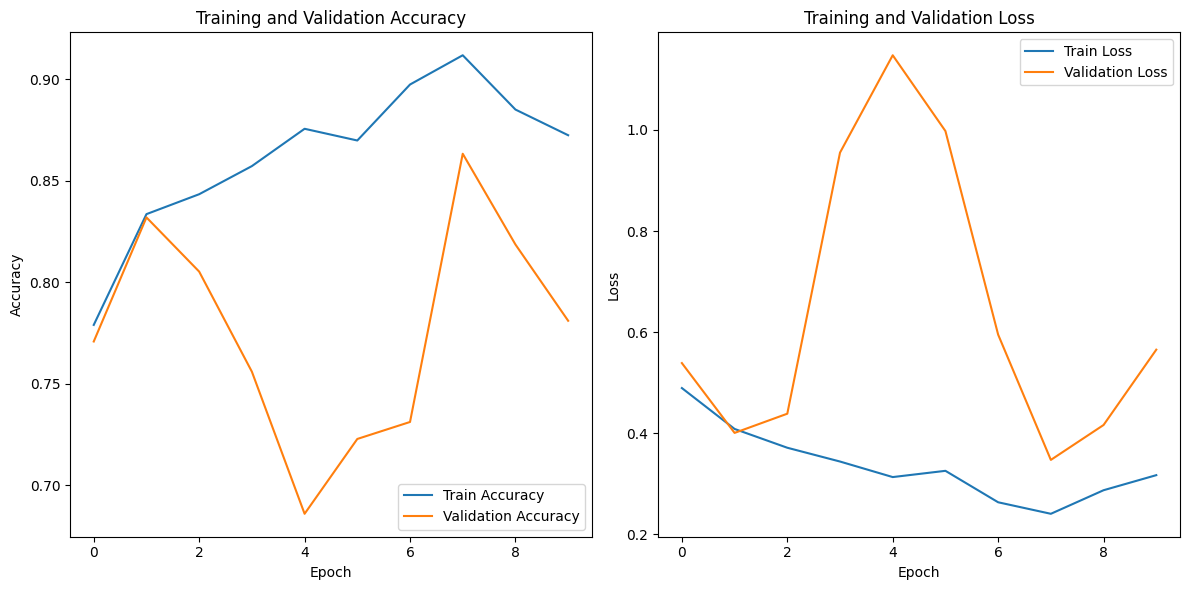

In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(resnet_history.history['accuracy'], label='Train Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(resnet_history.history['loss'], label='Train Loss')
plt.plot(resnet_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [11]:
VGGNet = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=tf.keras.Input(shape=IMG_SHAPE)
)
VGGNet.trainable = True
VGGNet.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
cnn_model2 = Sequential([
    VGGNet,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(catagories, activation='softmax')
])

opt = tf.keras.optimizers.Adam(0.001)
cnn_model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

In [13]:
VGGNet_history = cnn_model2.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
    )

Epoch 1/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 577s 197ms/step - AUC: 0.7789 - accuracy: 0.7108 - loss: 0.5569 - val_AUC: 0.9044 - val_accuracy: 0.8097 - val_loss: 0.3901
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 511s 186ms/step - AUC: 0.8600 - accuracy: 0.7816 - loss: 0.4650 - val_AUC: 0.5950 - val_accuracy: 0.5950 - val_loss: 0.6751
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 504s 183ms/step - AUC: 0.5951 - accuracy: 0.5949 - loss: 0.6753 - val_AUC: 0.5950 - val_accuracy: 0.5950 - val_loss: 0.6751
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 508s 185ms/step - AUC: 0.5960 - accuracy: 0.5961 - loss: 0.6747 - val_AUC: 0.5950 - val_accuracy: 0.5950 - val_loss: 0.6750
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 510s 185ms/step - AUC: 0.5977 - accuracy: 0.5968 - loss: 0.6744 - val_AUC: 0.5950 - val_accuracy: 0.5950 - val_loss: 0.6750
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 505s 183ms/step - AUC: 0.5957 - accuracy: 0.5957 - loss: 0.6748 - val_AUC: 0.5950 - val_accuracy: 0.5950 - val_loss: 0.6750
Epoc

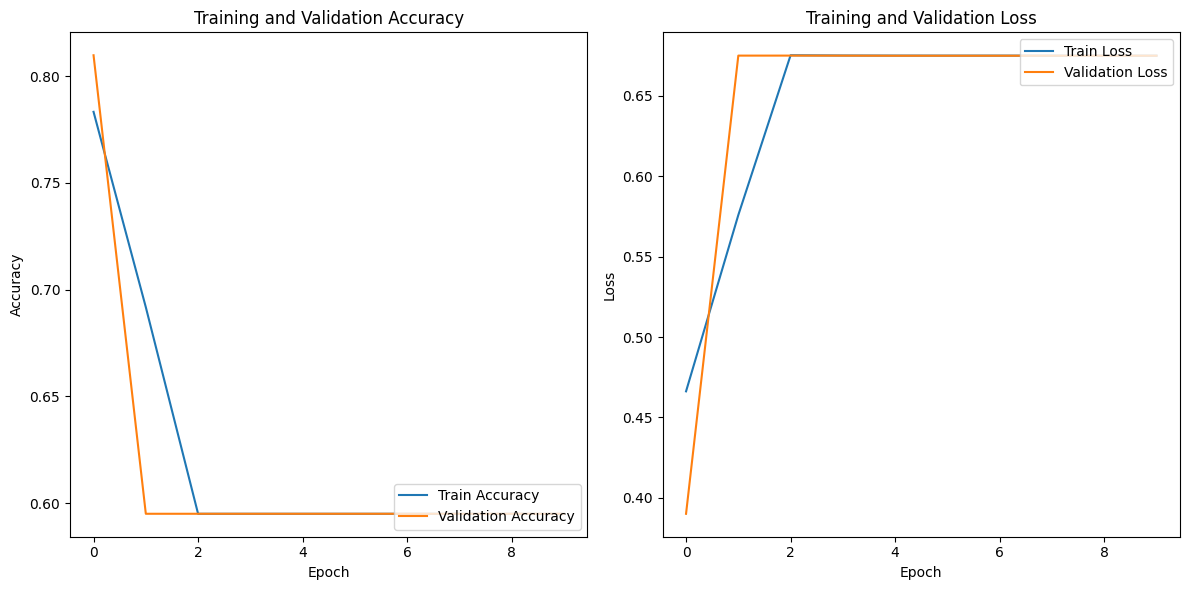

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(VGGNet_history.history['accuracy'], label='Train Accuracy')
plt.plot(VGGNet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(VGGNet_history.history['loss'], label='Train Loss')
plt.plot(VGGNet_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [15]:
InceptionV3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_tensor=tf.keras.Input(shape=IMG_SHAPE)
)
InceptionV3.trainable = True
InceptionV3.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 47, 47,    │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 47, 47,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 47, 47,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 45, 45,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 45, 45,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 22, 22,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 22, 22,    │      5,120 │ max_pooling2d_3[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 22,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 22, 22,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 20, 20,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 20,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 20, 20,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [16]:
cnn_model3 = Sequential([
    InceptionV3,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(catagories, activation='softmax')
])

opt = tf.keras.optimizers.Adam(0.001)
cnn_model3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

In [17]:
InceptionV3_history = cnn_model3.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
    )

Epoch 1/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 426s 130ms/step - AUC: 0.8675 - accuracy: 0.7908 - loss: 0.4639 - val_AUC: 0.8112 - val_accuracy: 0.7306 - val_loss: 0.6516
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 309s 112ms/step - AUC: 0.9312 - accuracy: 0.8647 - loss: 0.3378 - val_AUC: 0.9518 - val_accuracy: 0.8784 - val_loss: 0.2741
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 306s 111ms/step - AUC: 0.9319 - accuracy: 0.8637 - loss: 0.3327 - val_AUC: 0.5830 - val_accuracy: 0.5896 - val_loss: 1.0854
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 311s 113ms/step - AUC: 0.9235 - accuracy: 0.8556 - loss: 0.3532 - val_AUC: 0.9196 - val_accuracy: 0.8613 - val_loss: 0.3628
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 310s 112ms/step - AUC: 0.9533 - accuracy: 0.8957 - loss: 0.2719 - val_AUC: 0.9519 - val_accuracy: 0.8797 - val_loss: 0.2693
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 304s 110ms/step - AUC: 0.9599 - accuracy: 0.9046 - loss: 0.2488 - val_AUC: 0.9577 - val_accuracy: 0.8959 - val_loss: 0.2497
Epoc

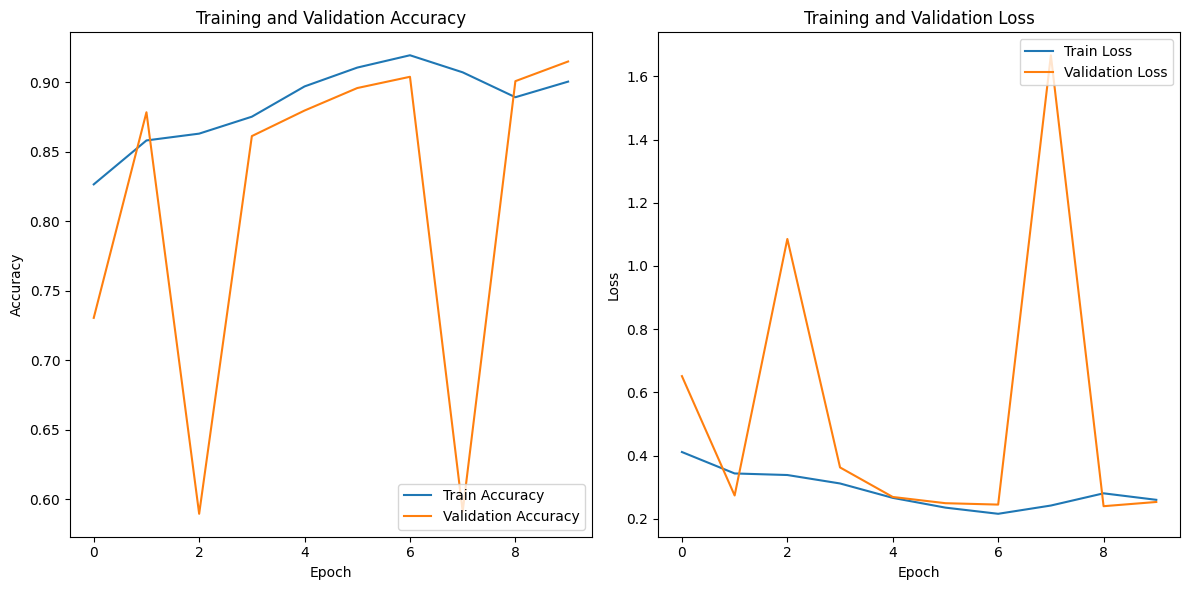

In [18]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(InceptionV3_history.history['accuracy'], label='Train Accuracy')
plt.plot(InceptionV3_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(InceptionV3_history.history['loss'], label='Train Loss')
plt.plot(InceptionV3_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Best Model

In [19]:
import pickle
cnn_model3.save('/kaggle/working/week3miniproj.keras')
pickle.dump(InceptionV3_history.history, open(f'histopathologic-cancer-detection_v01.pk1','wb'))

This just saves the model, not necessary for the final submission but it was put here in case I needed to make a seperate notebook.

## Testing

The testing phase is only slightly different than training, in that the dataset I pass is now using the test set and since I already have the model, I just need to pipe through the new datagenerators into the cnn model.

In [20]:
test_images = '/kaggle/input/histopathologic-cancer-detection/test/'
test_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
test_df['filename'] = test_df['id'] + '.tif'
test_df['label'] = test_df['label'].astype(str)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_images,
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=64,
    shuffle = True,
    class_mode='categorical')

Found 57458 validated image filenames belonging to 1 classes.


In [21]:
test_preds = cnn_model3.predict(test_generator)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 397s 437ms/step


In [22]:
# Convert probabilities to predicted class labels
predicted_labels = np.argmax(test_preds, axis=1)

submission_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')

# Create the submission DataFrame using filenames from test_df
submission = pd.DataFrame({'id': submission_df['id'], 'label': predicted_labels})

# Save the DataFrame to a CSV file for submission
submission.to_csv('submission.csv', index=False)

In [23]:
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,1
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,1
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,1


## Discussion

As a note, for this notebook I was unaware of the hardware acceleration so I did not want to try chaning too many hyperparameters since it took too much time to compile the notebook each time, so I simply added a layer and just compared the three different architectures. I am positive that with some significant tuning I could have achieved a higher score and a much cleaner model, but now is not the time for that. The biggest takeaway I got was to understand how to have a functioning model that doesnt sacrifice too much processing time for better results since the dataset was immense, and I also noted that changing architectures dramatically changed the history output, making the choice of architecture clear as to what to use for this dataset.

## References

IMAGE VERIFICATION: https://pillow.readthedocs.io/en/stable/reference/Image.html

FULL TNENSORFLOW API: https://www.tensorflow.org/versions

TENSORFLOW DATAGEN: https://www.tensorflow.org/guide/data

KERAS: https://keras.io/guides/sequential_model/